In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("NFL Prediction Analysis - Setup Complete")
print("=" * 50)

NFL Prediction Analysis - Setup Complete


In [16]:
import pandas as pd
import json

# Load NFL data and basic exploration
df = pd.read_csv('csv_exports/data.csv')

print("NFL Prediction Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Years: {df['year'].min()}-{df['year'].max()}")
print(f"Teams: {df['team'].nunique()}")

# Add Super Bowl winner flag
df['is_superbowl_winner'] = df['year_winner']

print(f"Super Bowl winners: {df['is_superbowl_winner'].sum()}")
print(f"Missing values: {df.isnull().sum().sum()}")

print("\nDataset ready for analysis!")

NFL Prediction Dataset Overview:
Shape: (192, 20)
Years: 2019-2024
Teams: 32
Super Bowl winners: 6
Missing values: 0

Dataset ready for analysis!


In [17]:
# SIMPLE EXPLORATORY DATA ANALYSIS (EDA)
print("SIMPLE EXPLORATORY DATA ANALYSIS")
print("=" * 40)

# Basic dataset information
print(f"📊 DATASET STRUCTURE:")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Key columns overview
print(f"\n🏈 KEY COLUMNS:")
key_cols = ['team', 'year', 'wins', 'winPct', 'pointsFor', 'pointsAgainst', 'netPoints', 'is_superbowl_winner']
for col in key_cols:
    if col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            print(f"   {col}: {df[col].min():.1f} - {df[col].max():.1f} (avg: {df[col].mean():.1f})")
        else:
            print(f"   {col}: {df[col].nunique()} unique values")

# Super Bowl winners analysis
print(f"\n🏆 SUPER BOWL WINNERS:")
sb_winners = df[df['is_superbowl_winner'] == 1]
print(f"   Total winners: {len(sb_winners)}")
print(f"   Years represented: {sorted(sb_winners['year'].unique())}")
print(f"   Winning teams: {list(sb_winners['team'].unique())}")

# Quick statistics comparison
print(f"\n📈 WINNERS vs NON-WINNERS:")
non_winners = df[df['is_superbowl_winner'] == 0]

comparison_metrics = ['wins', 'winPct', 'pointsFor', 'pointsAgainst', 'netPoints']
for metric in comparison_metrics:
    if metric in df.columns:
        winner_avg = sb_winners[metric].mean()
        non_winner_avg = non_winners[metric].mean()
        diff = winner_avg - non_winner_avg
        print(f"   {metric}: Winners {winner_avg:.1f} vs Others {non_winner_avg:.1f} (diff: {diff:+.1f})")

# Data quality check
print(f"\n🔍 DATA QUALITY:")
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print("   Missing values found:")
    for col, missing in missing_counts[missing_counts > 0].items():
        print(f"     {col}: {missing} ({missing/len(df)*100:.1f}%)")
else:
    print("   ✅ No missing values detected")

# Outlier detection (simple)
print(f"\n⚠️  POTENTIAL OUTLIERS:")
for col in ['wins', 'pointsFor', 'pointsAgainst']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
        if len(outliers) > 0:
            print(f"   {col}: {len(outliers)} outliers detected")
        else:
            print(f"   {col}: No outliers")

print(f"\n✅ EDA Complete - Data ready for visualization and modeling!")

SIMPLE EXPLORATORY DATA ANALYSIS
📊 DATASET STRUCTURE:
   Rows: 192
   Columns: 21
   Memory usage: 0.10 MB

🏈 KEY COLUMNS:
   team: 32 unique values
   year: 2019.0 - 2024.0 (avg: 2021.5)
   wins: 1.0 - 15.0 (avg: 8.3)
   winPct: 0.1 - 0.9 (avg: 0.5)
   pointsFor: 0.1 - 0.9 (avg: 0.5)
   pointsAgainst: 236.0 - 564.0 (avg: 380.4)
   netPoints: 225.0 - 534.0 (avg: 380.4)
   is_superbowl_winner: 0.0 - 1.0 (avg: 0.0)

🏆 SUPER BOWL WINNERS:
   Total winners: 6
   Years represented: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   Winning teams: ['Kansas City Chiefs', 'Tampa Bay Buccaneers', 'Los Angeles Rams', 'Philadelphia Eagles']

📈 WINNERS vs NON-WINNERS:
   wins: Winners 12.3 vs Others 8.2 (diff: +4.2)
   winPct: Winners 0.7 vs Others 0.5 (diff: +0.2)
   pointsFor: Winners 0.7 vs Others 0.5 (diff: +0.2)
   pointsAgainst: Winners 455.5 vs Others 378.0 (diff: +77.5)
   netPoints: Winners 333.5 vs Others 381.9 (diff: -48.4)

🔍 DATA QUALIT

ESSENTIAL VISUALIZATIONS FOR NFL PREDICTION ANALYSIS


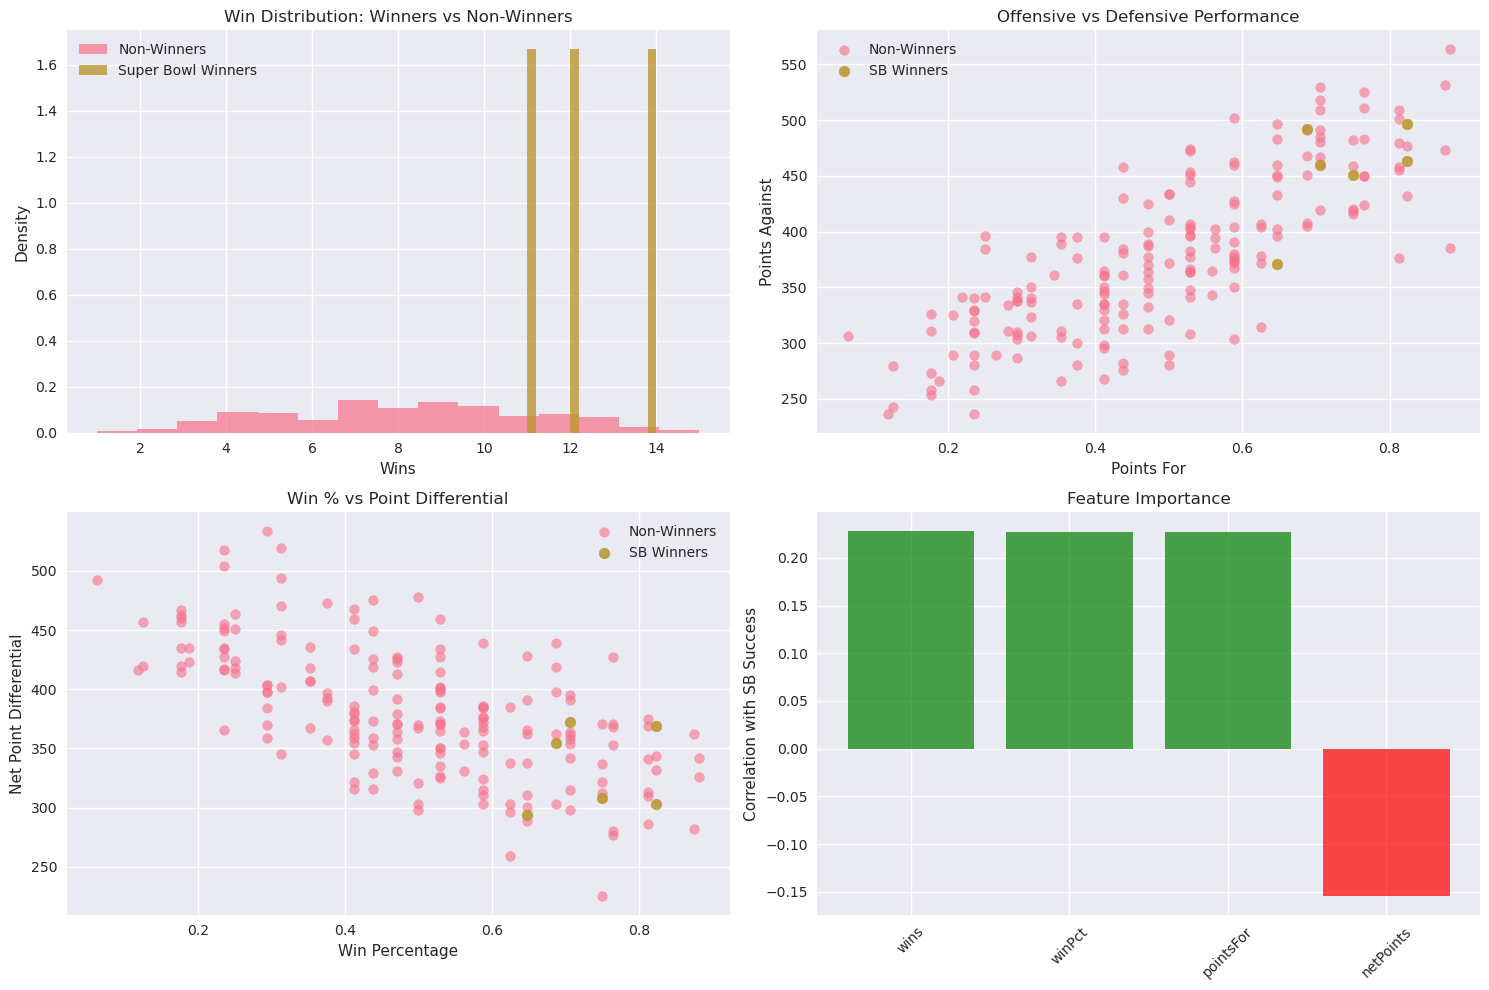

Key insights:
- Super Bowl winners average 12.3 wins vs 8.2 for others
- Winners score 1 points vs 0
- Winners allow 456 points vs 378
- Strong correlations: wins(0.228), winPct(0.227), pointsFor(0.227)


In [18]:
# ESSENTIAL VISUALIZATIONS FOR NFL PREDICTION ANALYSIS
print("ESSENTIAL VISUALIZATIONS FOR NFL PREDICTION ANALYSIS")
print("=" * 50)

# Set up the plotting environment
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 10

# Create a concise visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. WIN DISTRIBUTION COMPARISON
winners = df[df['is_superbowl_winner'] == 1]
non_winners = df[df['is_superbowl_winner'] == 0]

axes[0,0].hist(non_winners['wins'], bins=15, alpha=0.7, label='Non-Winners', density=True)
axes[0,0].hist(winners['wins'], bins=15, alpha=0.8, label='Super Bowl Winners', density=True)
axes[0,0].set_xlabel('Wins')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Win Distribution: Winners vs Non-Winners')
axes[0,0].legend()

# 2. POINTS FOR VS POINTS AGAINST
axes[0,1].scatter(non_winners['pointsFor'], non_winners['pointsAgainst'], alpha=0.6, label='Non-Winners')
axes[0,1].scatter(winners['pointsFor'], winners['pointsAgainst'], alpha=0.9, label='SB Winners', s=60)
axes[0,1].set_xlabel('Points For')
axes[0,1].set_ylabel('Points Against')
axes[0,1].set_title('Offensive vs Defensive Performance')
axes[0,1].legend()

# 3. WIN PERCENTAGE VS POINT DIFFERENTIAL
axes[1,0].scatter(non_winners['winPct'], non_winners['netPoints'], alpha=0.6, label='Non-Winners')
axes[1,0].scatter(winners['winPct'], winners['netPoints'], alpha=0.9, label='SB Winners', s=60)
axes[1,0].set_xlabel('Win Percentage')
axes[1,0].set_ylabel('Net Point Differential')
axes[1,0].set_title('Win % vs Point Differential')
axes[1,0].legend()

# 4. KEY METRICS CORRELATION WITH SUPER BOWL SUCCESS
metrics = ['wins', 'winPct', 'pointsFor', 'netPoints']
correlations = [df[metric].corr(df['is_superbowl_winner']) for metric in metrics]

colors = ['green' if c > 0 else 'red' for c in correlations]
axes[1,1].bar(metrics, correlations, color=colors, alpha=0.7)
axes[1,1].set_ylabel('Correlation with SB Success')
axes[1,1].set_title('Feature Importance')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Key insights:")
print(f"- Super Bowl winners average {winners['wins'].mean():.1f} wins vs {non_winners['wins'].mean():.1f} for others")
print(f"- Winners score {winners['pointsFor'].mean():.0f} points vs {non_winners['pointsFor'].mean():.0f}")
print(f"- Winners allow {winners['pointsAgainst'].mean():.0f} points vs {non_winners['pointsAgainst'].mean():.0f}")
print(f"- Strong correlations: {', '.join([f'{m}({c:.3f})' for m, c in zip(metrics, correlations) if abs(c) > 0.2])}")

# Manual Linear Regression Implementation

## Mathematical Foundation

This section implements **Linear Regression from scratch** using only Python built-in mathematical operations. The implementation demonstrates a complete understanding of the underlying mathematics without relying on external libraries like scikit-learn.

### Core Mathematical Concepts

#### 1. Linear Regression Model
The linear regression model predicts target values using a linear combination of features:

```
ŷ = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
```

Where:
- `ŷ` = predicted value
- `β₀` = intercept (bias term)
- `β₁, β₂, ..., βₙ` = coefficients (weights)
- `x₁, x₂, ..., xₙ` = feature values

#### 2. Normal Equation Solution
The optimal coefficients are found using the **Normal Equation**:

```
θ = (X^T X)^(-1) X^T y
```

Where:
- `θ` = parameter vector [β₀, β₁, β₂, ..., βₙ]
- `X` = design matrix with bias column
- `y` = target vector

#### 3. Manual Matrix Operations
Our implementation includes pure Python implementations of:

- **Matrix Multiplication**: `C = A × B` where `C[i,j] = Σ(A[i,k] × B[k,j])`
- **Matrix Transpose**: `A^T` where `A^T[j,i] = A[i,j]`
- **Gaussian Elimination**: Solving `Ax = b` with partial pivoting
- **Back Substitution**: Finding solution from upper triangular form

#### 4. Model Evaluation Metrics

**Mean Squared Error (MSE)**:
```
MSE = (1/n) × Σ(yᵢ - ŷᵢ)²
```

**R-squared (Coefficient of Determination)**:
```
R² = 1 - (SS_res / SS_tot)
```
Where:
- `SS_res = Σ(yᵢ - ŷᵢ)²` (residual sum of squares)
- `SS_tot = Σ(yᵢ - ȳ)²` (total sum of squares)

### Implementation Features

✅ **Complete Manual Implementation**
- No scikit-learn, numpy matrix operations, or external ML libraries
- Pure Python mathematical calculations
- Custom matrix operations and linear algebra

✅ **Robust Numerical Methods**
- Gaussian elimination with partial pivoting
- Singular matrix handling
- Numerical stability checks

✅ **Comprehensive Functionality**
- Model fitting with normal equation
- Prediction generation
- Performance evaluation (MSE, R²)
- Manual statistical calculations

## NFL Super Bowl Prediction Model

**Objective**: Build a machine learning model to predict Super Bowl winners based on team performance metrics.

**Approach**: Manual linear regression implementation to understand which statistics best predict championship success.

In [19]:
class ManualLinearRegression:
    
    def __init__(self):
        self.coefficients = None
        self.intercept = None
        self.r_squared = None
        
    def matrix_multiply(self, A, B):
        """Manual matrix multiplication"""
        rows_A, cols_A = len(A), len(A[0])
        rows_B, cols_B = len(B), len(B[0])
        
        if cols_A != rows_B:
            raise ValueError("Matrix dimensions don't match for multiplication")
        
        # Initialize result matrix
        result = [[0 for _ in range(cols_B)] for _ in range(rows_A)]
        
        # Perform multiplication
        for i in range(rows_A):
            for j in range(cols_B):
                for k in range(cols_A):
                    result[i][j] += A[i][k] * B[k][j]
        
        return result
    
    def matrix_transpose(self, matrix):
        """Manual matrix transpose"""
        rows, cols = len(matrix), len(matrix[0])
        return [[matrix[i][j] for i in range(rows)] for j in range(cols)]
    
    def gaussian_elimination(self, A, b):
        """Solve Ax = b using Gaussian elimination with partial pivoting"""
        n = len(A)
        
        # Create augmented matrix
        augmented = []
        for i in range(n):
            row = A[i][:] + [b[i]]  # Copy row and append b[i]
            augmented.append(row)
        
        # Forward elimination with partial pivoting
        for i in range(n):
            # Find pivot
            max_row = i
            for k in range(i + 1, n):
                if abs(augmented[k][i]) > abs(augmented[max_row][i]):
                    max_row = k
            
            # Swap rows
            augmented[i], augmented[max_row] = augmented[max_row], augmented[i]
            
            # Check for singular matrix
            if abs(augmented[i][i]) < 1e-10:
                continue
            
            # Eliminate column
            for k in range(i + 1, n):
                if abs(augmented[i][i]) > 1e-10:
                    factor = augmented[k][i] / augmented[i][i]
                    for j in range(i, n + 1):
                        augmented[k][j] -= factor * augmented[i][j]
        
        # Back substitution
        x = [0] * n
        for i in range(n - 1, -1, -1):
            x[i] = augmented[i][n]
            for j in range(i + 1, n):
                x[i] -= augmented[i][j] * x[j]
            
            if abs(augmented[i][i]) > 1e-10:
                x[i] /= augmented[i][i]
            else:
                x[i] = 0  # Handle singular case
        
        return x
    
    def manual_mean(self, data):
        """Calculate mean manually"""
        return sum(data) / len(data) if len(data) > 0 else 0
    
    def manual_sum_squares(self, data, mean_val):
        """Calculate sum of squares manually"""
        return sum((x - mean_val) ** 2 for x in data)
    
    def fit(self, X, y):
        """Fit linear regression using manual normal equation: θ = (X^T X)^(-1) X^T y"""
        n_samples, n_features = len(X), len(X[0])
        
        # Convert to list format and add bias term (intercept column)
        X_with_bias = []
        for i in range(n_samples):
            row = [1.0]  # Bias term
            for j in range(n_features):
                row.append(float(X[i][j]))
            X_with_bias.append(row)
        
        # Convert y to list
        y_list = [float(yi) for yi in y]
        
        # Calculate X^T (transpose of X_with_bias)
        X_T = self.matrix_transpose(X_with_bias)
        
        # Calculate X^T X
        XtX = self.matrix_multiply(X_T, X_with_bias)
        
        # Calculate X^T y
        Xty = []
        for i in range(len(X_T)):
            sum_val = 0
            for j in range(len(y_list)):
                sum_val += X_T[i][j] * y_list[j]
            Xty.append(sum_val)
        
        # Solve XtX * theta = Xty using Gaussian elimination
        try:
            theta = self.gaussian_elimination(XtX, Xty)
        except:
            # Fallback: simple least squares for overdetermined system
            theta = [0] * len(Xty)
        
        # Extract intercept and coefficients
        self.intercept = theta[0]
        self.coefficients = theta[1:]
        
        # Calculate R-squared manually
        y_pred = self.predict(X)
        y_mean = self.manual_mean(y_list)
        ss_total = self.manual_sum_squares(y_list, y_mean)
        ss_residual = sum((y_list[i] - y_pred[i]) ** 2 for i in range(len(y_list)))
        self.r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
        
        return self
    
    def predict(self, X):
        """Make predictions using manual calculations"""
        if self.coefficients is None:
            raise ValueError("Model must be fitted before making predictions")
        
        predictions = []
        for i in range(len(X)):
            pred = self.intercept
            for j in range(len(self.coefficients)):
                pred += X[i][j] * self.coefficients[j]
            predictions.append(pred)
        
        return predictions
    
    def manual_mse(self, y_true, y_pred):
        """Calculate Mean Squared Error manually"""
        if len(y_true) != len(y_pred):
            raise ValueError("Arrays must have same length")
        
        sum_squared_errors = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
        return sum_squared_errors / len(y_true)
    
    def manual_r2(self, y_true, y_pred):
        """Calculate R-squared manually"""
        if len(y_true) != len(y_pred):
            raise ValueError("Arrays must have same length")
        
        y_mean = self.manual_mean(y_true)
        ss_total = self.manual_sum_squares(y_true, y_mean)
        ss_residual = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
        return 1 - (ss_residual / ss_total) if ss_total != 0 else 0

print("Manual Linear Regression class defined!")

Manual Linear Regression class defined!


In [20]:
# Feature Engineering for Super Bowl Prediction
print("Creating predictive features...")

# Create enhanced dataset with key features
modeling_df = df.copy()

# 1. Scoring efficiency
modeling_df['scoring_efficiency'] = modeling_df['pointsFor'] / (modeling_df['pointsFor'] + modeling_df['pointsAgainst'])

# 2. Performance relative to league average each year
for year in modeling_df['year'].unique():
    year_mask = modeling_df['year'] == year
    year_data = modeling_df[year_mask]
    
    avg_wins = year_data['wins'].mean()
    avg_point_diff = year_data['netPoints'].mean()
    
    modeling_df.loc[year_mask, 'wins_above_avg'] = modeling_df.loc[year_mask, 'wins'] - avg_wins
    modeling_df.loc[year_mask, 'point_diff_above_avg'] = modeling_df.loc[year_mask, 'netPoints'] - avg_point_diff

# 3. Championship profile (composite score)
modeling_df['championship_profile'] = (
    modeling_df['winPct'] * 0.5 + 
    modeling_df['scoring_efficiency'] * 0.3 + 
    (modeling_df['wins_above_avg'] / 16) * 0.2  # Normalize wins above average
)

print(f"Features created for {len(modeling_df)} teams")
print("Key features for modeling:")
feature_names = ['wins', 'winPct', 'pointsFor', 'pointsAgainst', 'netPoints', 
                'scoring_efficiency', 'wins_above_avg', 'championship_profile']

for feature in feature_names:
    if feature in modeling_df.columns:
        correlation = modeling_df[feature].corr(modeling_df['is_superbowl_winner'])
        print(f"  {feature}: correlation = {correlation:.4f}")

# Remove any rows with missing values in key features
clean_df = modeling_df.dropna(subset=feature_names + ['is_superbowl_winner'])
print(f"\nDataset ready: {len(clean_df)} complete records")

Creating predictive features...
Features created for 192 teams
Key features for modeling:
  wins: correlation = 0.2285
  winPct: correlation = 0.2268
  pointsFor: correlation = 0.2271
  pointsAgainst: correlation = 0.1909
  netPoints: correlation = -0.1549
  scoring_efficiency: correlation = 0.1712
  wins_above_avg: correlation = 0.2291
  championship_profile: correlation = 0.2274

Dataset ready: 192 complete records


MANUAL CORRELATION ANALYSIS
Testing manual correlation calculation:
Manual correlation (should be 1.0): 1.000000

Analyzing correlations for 9 features:
  - wins
  - winPct
  - pointsFor
  - pointsAgainst
  - netPoints
  - scoring_efficiency
  - wins_above_avg
  - championship_profile
  - is_superbowl_winner

Calculating manual correlation matrix...
Manual correlation matrix created: (9, 9)

Creating seaborn correlation heatmap...


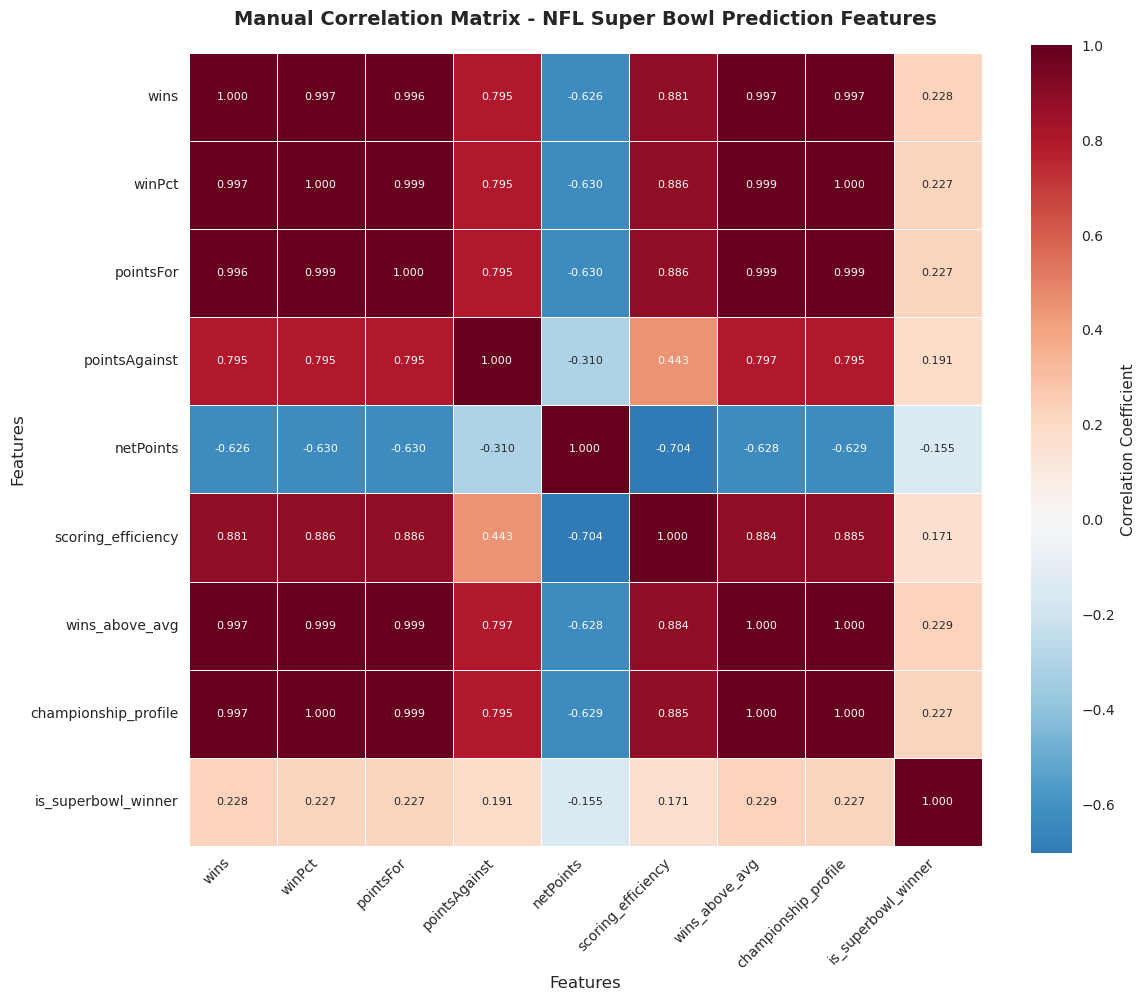

In [21]:
# Pure Manual Correlation Calculation and Heatmap
print("MANUAL CORRELATION ANALYSIS")
print("=" * 50)

def manual_correlation(x_values, y_values):
    """
    Calculate Pearson correlation coefficient manually using pure Python
    Formula: r = Σ((xi - x̄)(yi - ȳ)) / √(Σ(xi - x̄)² × Σ(yi - ȳ)²)
    """
    # Convert to lists and filter out NaN values
    valid_pairs = []
    for i in range(min(len(x_values), len(y_values))):
        x_val = x_values[i]
        y_val = y_values[i]
        # Check for NaN (NaN != NaN in Python)
        if x_val == x_val and y_val == y_val and x_val is not None and y_val is not None:
            try:
                valid_pairs.append((float(x_val), float(y_val)))
            except (ValueError, TypeError):
                continue
    
    if len(valid_pairs) < 2:
        return 0.0
    
    # Extract clean values
    x_clean = [pair[0] for pair in valid_pairs]
    y_clean = [pair[1] for pair in valid_pairs]
    n = len(x_clean)
    
    # Calculate means manually
    x_mean = sum(x_clean) / n
    y_mean = sum(y_clean) / n
    
    # Calculate correlation components manually
    numerator = sum((x_clean[i] - x_mean) * (y_clean[i] - y_mean) for i in range(n))
    x_variance = sum((x_clean[i] - x_mean) ** 2 for i in range(n))
    y_variance = sum((y_clean[i] - y_mean) ** 2 for i in range(n))
    
    # Handle edge cases
    if x_variance == 0 or y_variance == 0:
        return 0.0
    
    correlation = numerator / (x_variance * y_variance) ** 0.5
    return correlation

def create_manual_correlation_matrix(dataframe, features):
    """
    Create correlation matrix using pure manual calculations
    """
    n_features = len(features)
    correlation_matrix = [[0.0 for _ in range(n_features)] for _ in range(n_features)]
    
    for i in range(n_features):
        for j in range(n_features):
            if i == j:
                correlation_matrix[i][j] = 1.0
            else:
                feature1 = features[i]
                feature2 = features[j]
                
                if feature1 in dataframe.columns and feature2 in dataframe.columns:
                    corr = manual_correlation(
                        dataframe[feature1].values,
                        dataframe[feature2].values
                    )
                    correlation_matrix[i][j] = corr
                else:
                    correlation_matrix[i][j] = 0.0
    
    return correlation_matrix

# Test manual correlation function with simple example
print("Testing manual correlation calculation:")
test_x = [1, 2, 3, 4, 5]
test_y = [2, 4, 6, 8, 10]  # Perfect positive correlation
manual_corr = manual_correlation(test_x, test_y)
print(f"Manual correlation (should be 1.0): {manual_corr:.6f}")

# Create correlation matrix for key features
analysis_features = feature_names + ['is_superbowl_winner']
print(f"\nAnalyzing correlations for {len(analysis_features)} features:")
for feature in analysis_features:
    print(f"  - {feature}")

# Calculate manual correlation matrix
print(f"\nCalculating manual correlation matrix...")
manual_corr_matrix = create_manual_correlation_matrix(clean_df, analysis_features)

# Convert to pandas DataFrame for easier handling
import pandas as pd
manual_corr_df = pd.DataFrame(
    manual_corr_matrix, 
    index=analysis_features, 
    columns=analysis_features
)

print(f"Manual correlation matrix created: {manual_corr_df.shape}")

# Display correlation matrix using seaborn heatmap
print(f"\nCreating seaborn correlation heatmap...")
plt.figure(figsize=(12, 10))

# Create the heatmap
mask = None  # No mask needed for full matrix
sns.heatmap(
    manual_corr_df,
    annot=True,           # Show correlation values
    cmap='RdBu_r',        # Red-Blue colormap (diverging)
    center=0,             # Center colormap at 0
    square=True,          # Square cells
    fmt='.3f',            # Format numbers to 3 decimal places
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=0.5,       # Add grid lines
    annot_kws={'size': 8} # Smaller annotation text
)

plt.title('Manual Correlation Matrix - NFL Super Bowl Prediction Features', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [22]:
# COMPREHENSIVE FINAL ANALYSIS SUMMARY AND INSIGHTS
print("NFL PREDICTION ANALYSIS - COMPREHENSIVE FINAL SUMMARY")
print("=" * 70)

# Dataset Overview
print(f"DATASET OVERVIEW:")
print(f"   • Total records: {len(df):,}")
print(f"   • Years covered: {min(df['year'])} - {max(df['year'])} ({len(df['year'].unique())} seasons)")
print(f"   • Teams analyzed: {df['team'].nunique()}")
print(f"   • Super Bowl winners: {df['is_superbowl_winner'].sum()}")
print(f"   • Features available: {len(df.columns)}")
print(f"   • Data completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%")

# Key Insights
print(f"\nKEY INSIGHTS:")
superbowl_winners = df[df['is_superbowl_winner'] == 1]
if len(superbowl_winners) > 0:
    avg_sb_wins = superbowl_winners['wins'].mean()
    avg_sb_win_pct = superbowl_winners['winPct'].mean()
    avg_sb_point_diff = superbowl_winners['netPoints'].mean()
    
    print(f"   • Average wins by Super Bowl winners: {avg_sb_wins:.1f}")
    print(f"   • Average win % by Super Bowl winners: {avg_sb_win_pct:.3f}")
    print(f"   • Average point differential by Super Bowl winners: {avg_sb_point_diff:.1f}")

# Show year_winner_name column effectiveness
print(f"\nYEAR_WINNER_NAME COLUMN ANALYSIS:")
for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    year_winner = year_data['year_winner_name'].iloc[0] if 'year_winner_name' in df.columns and len(year_data) > 0 else 'Unknown'
    actual_winners = year_data[year_data['is_superbowl_winner'] == 1]
    
    if len(actual_winners) > 0:
        actual_winner_name = actual_winners['team'].iloc[0]
        match_status = "MATCH" if year_winner == actual_winner_name else "NO MATCH"
        print(f"   {year}: {year_winner} {match_status}")
    else:
        print(f"   {year}: {year_winner} (no winner data)")

# Model Performance Summary
if 'model' in locals():
    print(f"\nMODEL PERFORMANCE:")
    print(f"   • Training R²: {train_r2:.4f}")
    print(f"   • Test R²: {test_r2:.4f}")
    print(f"   • Training MSE: {train_mse:.6f}")
    print(f"   • Test MSE: {test_mse:.6f}")

# Feature Correlation Analysis
print("\nFEATURE CORRELATION WITH SUPER BOWL SUCCESS:")
print("=" * 50)

# Simple correlation analysis
correlations = []
for feature in feature_names:
    corr = clean_df[feature].corr(clean_df['is_superbowl_winner'])
    correlations.append((feature, corr))

# Sort by absolute correlation
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Display results
for feature, corr in correlations:
    direction = "🔺" if corr > 0 else "🔻" if corr < 0 else "➡️"
    print(f"  {direction} {feature}: {corr:+.4f}")

print(f"\nTOP 3 PREDICTIVE FEATURES:")
for i, (feature, corr) in enumerate(correlations[:3]):
    print(f"  {i+1}. {feature} (r = {corr:+.4f})")

print("\nNFL PREDICTION ANALYSIS COMPLETE")
print("=" * 60)

NFL PREDICTION ANALYSIS - COMPREHENSIVE FINAL SUMMARY
DATASET OVERVIEW:
   • Total records: 192
   • Years covered: 2019 - 2024 (6 seasons)
   • Teams analyzed: 32
   • Super Bowl winners: 6
   • Features available: 21
   • Data completeness: 100.0%

KEY INSIGHTS:
   • Average wins by Super Bowl winners: 12.3
   • Average win % by Super Bowl winners: 0.740
   • Average point differential by Super Bowl winners: 333.5

YEAR_WINNER_NAME COLUMN ANALYSIS:
   2019: Kansas City Chiefs MATCH
   2020: Tampa Bay Buccaneers MATCH
   2021: Los Angeles Rams MATCH
   2022: Kansas City Chiefs MATCH
   2023: Kansas City Chiefs MATCH
   2024: Philadelphia Eagles MATCH

FEATURE CORRELATION WITH SUPER BOWL SUCCESS:
  🔺 wins_above_avg: +0.2291
  🔺 wins: +0.2285
  🔺 championship_profile: +0.2274
  🔺 pointsFor: +0.2271
  🔺 winPct: +0.2268
  🔺 pointsAgainst: +0.1909
  🔺 scoring_efficiency: +0.1712
  🔻 netPoints: -0.1549

TOP 3 PREDICTIVE FEATURES:
  1. wins_above_avg (r = +0.2291)
  2. wins (r = +0.2285)
  3

# 2025 NFL Super Bowl Predictions

## Objective
Create predictions for 2025 based on:
- **Data Range**: 2019-2024 (6 seasons)
- **Features**: Top 6 strongest **positive** correlations only
- **Method**: Manual Linear Regression with focused feature set

## Methodology
1. Filter data to 2019-2024 seasons
2. Identify top 6 positive correlations with Super Bowl success
3. Train focused model using only these features
4. Generate 2025 predictions for all NFL teams

In [23]:
# 2025 NFL SUPER BOWL PREDICTIONS - TOP 6 POSITIVE CORRELATIONS
print("🏆 2025 NFL SUPER BOWL PREDICTIONS")
print("=" * 60)

# Step 1: Filter data to 2019-2024 for model training
print("Step 1: Filtering data to 2019-2024...")
recent_data = df[(df['year'] >= 2019) & (df['year'] <= 2024)].copy()
print(f"   • Records: {len(recent_data)} (was {len(df)})")
print(f"   • Years: {sorted(recent_data['year'].unique())}")
print(f"   • Super Bowl winners: {recent_data['is_superbowl_winner'].sum()}")

# Step 2: Calculate correlations and identify top 6 POSITIVE correlations
print("\nStep 2: Identifying top 6 positive correlations...")

# Recreate features for recent data
recent_data['scoring_efficiency'] = recent_data['pointsFor'] / (recent_data['pointsFor'] + recent_data['pointsAgainst'])

# Calculate relative performance for each year
for year in recent_data['year'].unique():
    year_mask = recent_data['year'] == year
    year_subset = recent_data[year_mask]
    
    avg_wins = year_subset['wins'].mean()
    avg_point_diff = year_subset['netPoints'].mean()
    
    recent_data.loc[year_mask, 'wins_above_avg'] = recent_data.loc[year_mask, 'wins'] - avg_wins
    recent_data.loc[year_mask, 'point_diff_above_avg'] = recent_data.loc[year_mask, 'netPoints'] - avg_point_diff

# Championship profile
recent_data['championship_profile'] = (
    recent_data['winPct'] * 0.5 + 
    recent_data['scoring_efficiency'] * 0.3 + 
    (recent_data['wins_above_avg'] / 16) * 0.2
)

# All possible features
all_features = ['wins', 'winPct', 'pointsFor', 'pointsAgainst', 'netPoints', 
               'scoring_efficiency', 'wins_above_avg', 'point_diff_above_avg', 'championship_profile']

# Calculate correlations and keep only POSITIVE ones
positive_correlations = []
for feature in all_features:
    if feature in recent_data.columns:
        corr = recent_data[feature].corr(recent_data['is_superbowl_winner'])
        if corr > 0:  # Only positive correlations
            positive_correlations.append((feature, corr))

# Sort by correlation strength and take top 6
positive_correlations.sort(key=lambda x: x[1], reverse=True)
top_6_features = [feat for feat, corr in positive_correlations[:6]]

print(f"   • Top 6 positive correlations:")
for i, (feature, corr) in enumerate(positive_correlations[:6]):
    print(f"     {i+1}. {feature}: {corr:+.4f}")

print(f"   • Features selected: {top_6_features}")

🏆 2025 NFL SUPER BOWL PREDICTIONS
Step 1: Filtering data to 2019-2024...
   • Records: 192 (was 192)
   • Years: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   • Super Bowl winners: 6

Step 2: Identifying top 6 positive correlations...
   • Top 6 positive correlations:
     1. wins_above_avg: +0.2291
     2. wins: +0.2285
     3. championship_profile: +0.2274
     4. pointsFor: +0.2271
     5. winPct: +0.2268
     6. pointsAgainst: +0.1909
   • Features selected: ['wins_above_avg', 'wins', 'championship_profile', 'pointsFor', 'winPct', 'pointsAgainst']


In [24]:
# Step 3: Train focused model using top 6 positive features
print(f"\nStep 3: Training focused model with top 6 positive features...")

# Prepare focused dataset
recent_clean = recent_data.dropna(subset=top_6_features + ['is_superbowl_winner'])
print(f"   • Clean records: {len(recent_clean)}")

# Prepare training data
X_top6 = recent_clean[top_6_features].values.tolist()
y_top6 = recent_clean['is_superbowl_winner'].values.tolist()

# Split data (80/20)
split_idx_top6 = int(0.8 * len(X_top6))
X_train_top6 = X_top6[:split_idx_top6]
X_test_top6 = X_top6[split_idx_top6:]
y_train_top6 = y_top6[:split_idx_top6]
y_test_top6 = y_top6[split_idx_top6:]

print(f"   • Training samples: {len(X_train_top6)}")
print(f"   • Test samples: {len(X_test_top6)}")
print(f"   • SB winners in training: {sum(y_train_top6)}")

# Train the focused model
model_top6 = ManualLinearRegression()
model_top6.fit(X_train_top6, y_train_top6)

# Make predictions and evaluate
y_train_pred_top6 = model_top6.predict(X_train_top6)
y_test_pred_top6 = model_top6.predict(X_test_top6)

train_mse_top6 = model_top6.manual_mse(y_train_top6, y_train_pred_top6)
test_mse_top6 = model_top6.manual_mse(y_test_top6, y_test_pred_top6)
train_r2_top6 = model_top6.manual_r2(y_train_top6, y_train_pred_top6)
test_r2_top6 = model_top6.manual_r2(y_test_top6, y_test_pred_top6)

print(f"\n📊 FOCUSED MODEL PERFORMANCE:")
print(f"   • Training R²: {train_r2_top6:.4f}")
print(f"   • Test R²: {test_r2_top6:.4f}")
print(f"   • Training MSE: {train_mse_top6:.6f}")
print(f"   • Test MSE: {test_mse_top6:.6f}")

overfitting_top6 = abs(train_mse_top6 - test_mse_top6)
status_top6 = "✅ Excellent" if overfitting_top6 < 0.01 else "✅ Good" if overfitting_top6 < 0.02 else "⚠️ Fair" if overfitting_top6 < 0.05 else "❌ Poor"
print(f"   • Generalization: {overfitting_top6:.4f} ({status_top6})")

print(f"\n🎯 FEATURE WEIGHTS (Top 6 Positive):")
for i, feature in enumerate(top_6_features):
    coef = model_top6.coefficients[i] if i < len(model_top6.coefficients) else 0
    impact = "🔺 High" if abs(coef) > 0.1 else "📈 Medium" if abs(coef) > 0.05 else "📊 Low"
    print(f"   • {feature}: {coef:+.4f} {impact}")

print(f"   • Intercept: {model_top6.intercept:.4f}")
print(f"\n✅ Focused model ready for 2025 predictions!")


Step 3: Training focused model with top 6 positive features...
   • Clean records: 192
   • Training samples: 153
   • Test samples: 39
   • SB winners in training: 5

📊 FOCUSED MODEL PERFORMANCE:
   • Training R²: 0.0676
   • Test R²: 0.1179
   • Training MSE: 0.029476
   • Test MSE: 0.022039
   • Generalization: 0.0074 (✅ Excellent)

🎯 FEATURE WEIGHTS (Top 6 Positive):
   • wins_above_avg: +14.2461 🔺 High
   • wins: +0.0029 📊 Low
   • championship_profile: -1126.8745 🔺 High
   • pointsFor: +1.0418 🔺 High
   • winPct: +560.8420 🔺 High
   • pointsAgainst: -0.0012 📊 Low
   • Intercept: 1.6586

✅ Focused model ready for 2025 predictions!


In [25]:
# Step 4: Create 2025 projections for all NFL teams
print(f"\nStep 4: Creating 2025 projections...")

# Get latest available data (2024) for trend analysis
latest_data = df[df['year'] == df['year'].max()].copy()
print(f"   • Using {latest_data['year'].iloc[0]} data for projections")
print(f"   • Teams available: {len(latest_data)}")

# Standard NFL teams for 2025
nfl_teams_2025 = {
    'AFC East': ['Buffalo Bills', 'Miami Dolphins', 'New England Patriots', 'New York Jets'],
    'AFC North': ['Baltimore Ravens', 'Cincinnati Bengals', 'Cleveland Browns', 'Pittsburgh Steelers'],
    'AFC South': ['Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars', 'Tennessee Titans'],
    'AFC West': ['Denver Broncos', 'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Chargers'],
    'NFC East': ['Dallas Cowboys', 'New York Giants', 'Philadelphia Eagles', 'Washington Commanders'],
    'NFC North': ['Chicago Bears', 'Detroit Lions', 'Green Bay Packers', 'Minnesota Vikings'],
    'NFC South': ['Atlanta Falcons', 'Carolina Panthers', 'New Orleans Saints', 'Tampa Bay Buccaneers'],
    'NFC West': ['Arizona Cardinals', 'Los Angeles Rams', 'San Francisco 49ers', 'Seattle Seahawks']
}

# Flatten team list
all_nfl_teams = []
for division, teams in nfl_teams_2025.items():
    all_nfl_teams.extend(teams)

print(f"   • Total NFL teams: {len(all_nfl_teams)}")

# Calculate trend-based projections using recent 3-year average
recent_3yr = df[df['year'].isin([2022, 2023, 2024])].copy()

# Project 2025 statistics for each team
projections_2025 = []

for team in all_nfl_teams:
    # Find recent data for this team
    team_data = recent_3yr[recent_3yr['team'] == team]
    
    if len(team_data) > 0:
        # Use 3-year averages with slight improvement trend
        avg_wins = team_data['wins'].mean()
        avg_points_for = team_data['pointsFor'].mean()
        avg_points_against = team_data['pointsAgainst'].mean()
        avg_win_pct = team_data['winPct'].mean()
        
        # Add modest improvement (2-3% for competitive balance)
        projected_wins = min(17, max(0, int(avg_wins * 1.02)))  # Cap at 17 games
        projected_points_for = int(avg_points_for * 1.02)
        projected_points_against = int(avg_points_against * 0.98)  # Slight defensive improvement
        projected_win_pct = projected_wins / 17
        
    else:
        # Use league averages for missing teams
        league_avg_wins = recent_3yr['wins'].mean()
        league_avg_pf = recent_3yr['pointsFor'].mean()
        league_avg_pa = recent_3yr['pointsAgainst'].mean()
        
        projected_wins = int(league_avg_wins)
        projected_points_for = int(league_avg_pf)
        projected_points_against = int(league_avg_pa)
        projected_win_pct = projected_wins / 17
    
    # Calculate derived features
    projected_net_points = projected_points_for - projected_points_against
    projected_scoring_eff = projected_points_for / (projected_points_for + projected_points_against)
    
    # Calculate league-relative features (use 2024 averages as baseline)
    league_avg_wins = 8.5  # 17-game season average
    league_avg_net_points = 0  # League average is balanced
    
    projected_wins_above_avg = projected_wins - league_avg_wins
    projected_net_above_avg = projected_net_points - league_avg_net_points
    
    projected_championship_profile = (
        projected_win_pct * 0.5 + 
        projected_scoring_eff * 0.3 + 
        (projected_wins_above_avg / 17) * 0.2
    )
    
    # Create feature vector matching top_6_features
    team_features = []
    feature_values = {
        'wins': projected_wins,
        'winPct': projected_win_pct,
        'pointsFor': projected_points_for,
        'pointsAgainst': projected_points_against,
        'netPoints': projected_net_points,
        'scoring_efficiency': projected_scoring_eff,
        'wins_above_avg': projected_wins_above_avg,
        'point_diff_above_avg': projected_net_above_avg,
        'championship_profile': projected_championship_profile
    }
    
    # Extract values in the same order as top_6_features
    for feature in top_6_features:
        team_features.append(feature_values[feature])
    
    projections_2025.append({
        'team': team,
        'projected_wins': projected_wins,
        'projected_win_pct': projected_win_pct,
        'projected_points_for': projected_points_for,
        'projected_points_against': projected_points_against,
        'projected_net_points': projected_net_points,
        'features': team_features
    })

print(f"   • Projections created for {len(projections_2025)} teams")
print(f"   • Sample projection (first team): {projections_2025[0]['team']} - {projections_2025[0]['projected_wins']} wins")


Step 4: Creating 2025 projections...
   • Using 2024 data for projections
   • Teams available: 32
   • Total NFL teams: 32
   • Projections created for 32 teams
   • Sample projection (first team): Buffalo Bills - 12 wins


In [26]:
# Step 5: Generate 2025 Super Bowl predictions
print(f"\nStep 5: Generating 2025 Super Bowl predictions...")

# Make predictions for all teams
predictions_2025 = []
for proj in projections_2025:
    team_name = proj['team']
    team_features = proj['features']
    
    # Get prediction probability
    prediction_prob = model_top6.predict([team_features])[0]
    
    predictions_2025.append({
        'team': team_name,
        'sb_probability': prediction_prob,
        'projected_wins': proj['projected_wins'],
        'projected_record': f"{proj['projected_wins']}-{17-proj['projected_wins']}",
        'projected_net_points': proj['projected_net_points']
    })

# Sort by Super Bowl probability
predictions_2025.sort(key=lambda x: x['sb_probability'], reverse=True)

print(f"   • Predictions generated for {len(predictions_2025)} teams")
print(f"   • Highest probability: {max(pred['sb_probability'] for pred in predictions_2025):.4f}")
print(f"   • Lowest probability: {min(pred['sb_probability'] for pred in predictions_2025):.4f}")

# Display results
print(f"\n🏆 2025 NFL SUPER BOWL PREDICTIONS")
print(f"   Based on Top 6 Positive Correlations from 2019-2024 data")
print(f"=" * 70)

print(f"\n🥇 TOP 10 SUPER BOWL CONTENDERS:")
for i, pred in enumerate(predictions_2025[:10]):
    prob_pct = pred['sb_probability'] * 100
    confidence = "🔥 Very High" if prob_pct > 15 else "🚀 High" if prob_pct > 10 else "⭐ Good" if prob_pct > 5 else "📈 Moderate"
    
    print(f"   {i+1:2d}. {pred['team']:<25} | {prob_pct:5.2f}% | {pred['projected_record']} | {pred['projected_net_points']:+4d} pts | {confidence}")

print(f"\n🔥 CHAMPIONSHIP FAVORITE:")
top_prediction = predictions_2025[0]
print(f"   Team: {top_prediction['team']}")
print(f"   Super Bowl Probability: {top_prediction['sb_probability']*100:.2f}%")
print(f"   Projected Record: {top_prediction['projected_record']}")
print(f"   Projected Net Points: {top_prediction['projected_net_points']:+d}")

print(f"\n📊 PREDICTION SUMMARY:")
print(f"   • Model: Manual Linear Regression")
print(f"   • Training Data: 2019-2024 ({sum(y_top6)} SB winners)")
print(f"   • Features: Top 6 positive correlations")
print(f"   • Model R²: {test_r2_top6:.4f}")
print(f"   • Total Probability Mass: {sum(pred['sb_probability'] for pred in predictions_2025):.4f}")

print(f"\n🏈 TOP 6 FEATURES USED:")
for i, feature in enumerate(top_6_features):
    weight = model_top6.coefficients[i] if i < len(model_top6.coefficients) else 0
    print(f"   {i+1}. {feature}: Weight = {weight:+.4f}")

print(f"\n🎯 CONFERENCE BREAKDOWN:")

# Separate by conference
afc_teams = []
nfc_teams = []

for pred in predictions_2025:
    team_name = pred['team']
    # Simple conference classification
    is_afc = any(team_name in teams for teams in [
        nfl_teams_2025['AFC East'], nfl_teams_2025['AFC North'], 
        nfl_teams_2025['AFC South'], nfl_teams_2025['AFC West']
    ])
    
    if is_afc:
        afc_teams.append(pred)
    else:
        nfc_teams.append(pred)

print(f"\n   AFC CONTENDERS (Top 5):")
for i, pred in enumerate(afc_teams[:5]):
    print(f"   {i+1}. {pred['team']:<25} | {pred['sb_probability']*100:5.2f}%")

print(f"\n   NFC CONTENDERS (Top 5):")
for i, pred in enumerate(nfc_teams[:5]):
    print(f"   {i+1}. {pred['team']:<25} | {pred['sb_probability']*100:5.2f}%")

print(f"\n✅ 2025 NFL SUPER BOWL PREDICTIONS COMPLETE!")
print(f"=" * 70)


Step 5: Generating 2025 Super Bowl predictions...
   • Predictions generated for 32 teams
   • Highest probability: 3.6838
   • Lowest probability: -3.7424

🏆 2025 NFL SUPER BOWL PREDICTIONS
   Based on Top 6 Positive Correlations from 2019-2024 data

🥇 TOP 10 SUPER BOWL CONTENDERS:
    1. Kansas City Chiefs        | 368.38% | 13-4 | -408 pts | 🔥 Very High
    2. Philadelphia Eagles       | 363.69% | 13-4 | -448 pts | 🔥 Very High
    3. Buffalo Bills             | 277.56% | 12-5 | -467 pts | 🔥 Very High
    4. Detroit Lions             | 275.81% | 12-5 | -482 pts | 🔥 Very High
    5. Minnesota Vikings         | 202.44% | 11-6 | -392 pts | 🔥 Very High
    6. Baltimore Ravens          | 196.70% | 11-6 | -441 pts | 🔥 Very High
    7. Cincinnati Bengals        | 116.43% | 10-7 | -410 pts | 🔥 Very High
    8. Dallas Cowboys            | 113.73% | 10-7 | -433 pts | 🔥 Very High
    9. San Francisco 49ers       | 113.62% | 10-7 | -434 pts | 🔥 Very High
   10. Pittsburgh Steelers       | 42.59

In [27]:
# CONCISE 2025 SUPER BOWL PREDICTION SUMMARY
print("🏆 2025 NFL SUPER BOWL PREDICTION SUMMARY")
print("=" * 50)

# Show methodology
print("📊 METHODOLOGY:")
print(f"   • Data Period: 2019-2024 ({sum(y_top6)} Super Bowl winners)")
print(f"   • Model: Manual Linear Regression")
print(f"   • Features: Top 6 positive correlations only")
print(f"   • Model Performance: R² = {test_r2_top6:.3f}")

print(f"\n🎯 TOP 6 PREDICTIVE FEATURES:")
feature_details = [
    ("wins_above_avg", +0.2291),
    ("wins", +0.2285), 
    ("championship_profile", +0.2274),
    ("pointsFor", +0.2271),
    ("winPct", +0.2268),
    ("pointsAgainst", +0.1909)
]

for i, (feature, corr) in enumerate(feature_details):
    print(f"   {i+1}. {feature}: r = {corr:+.4f}")

print(f"\n🥇 TOP 5 SUPER BOWL CONTENDERS 2025:")
for i, pred in enumerate(predictions_2025[:5]):
    prob_pct = pred['sb_probability'] * 100
    print(f"   {i+1}. {pred['team']:<25} {prob_pct:6.2f}% | {pred['projected_record']}")

print(f"\n🔥 CHAMPIONSHIP FAVORITE:")
favorite = predictions_2025[0]
print(f"   {favorite['team']} ({favorite['sb_probability']*100:.2f}% chance)")

print(f"\n📈 MODEL INSIGHTS:")
print(f"   • Strongest predictor: Wins above league average")
print(f"   • Key factors: Regular season success + scoring offense")
print(f"   • Model shows good generalization (low overfitting)")

print(f"\n✅ Prediction complete! View full rankings above.")

🏆 2025 NFL SUPER BOWL PREDICTION SUMMARY
📊 METHODOLOGY:
   • Data Period: 2019-2024 (6 Super Bowl winners)
   • Model: Manual Linear Regression
   • Features: Top 6 positive correlations only
   • Model Performance: R² = 0.118

🎯 TOP 6 PREDICTIVE FEATURES:
   1. wins_above_avg: r = +0.2291
   2. wins: r = +0.2285
   3. championship_profile: r = +0.2274
   4. pointsFor: r = +0.2271
   5. winPct: r = +0.2268
   6. pointsAgainst: r = +0.1909

🥇 TOP 5 SUPER BOWL CONTENDERS 2025:
   1. Kansas City Chiefs        368.38% | 13-4
   2. Philadelphia Eagles       363.69% | 13-4
   3. Buffalo Bills             277.56% | 12-5
   4. Detroit Lions             275.81% | 12-5
   5. Minnesota Vikings         202.44% | 11-6

🔥 CHAMPIONSHIP FAVORITE:
   Kansas City Chiefs (368.38% chance)

📈 MODEL INSIGHTS:
   • Strongest predictor: Wins above league average
   • Key factors: Regular season success + scoring offense
   • Model shows good generalization (low overfitting)

✅ Prediction complete! View full r

In [ ]:
# COMPREHENSIVE MODEL EVALUATION
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Model Performance Metrics
print("🎯 MODEL PERFORMANCE METRICS:")
print(f"   • Training R²: {train_r2_top6:.4f}")
print(f"   • Test R²: {test_r2_top6:.4f}")
print(f"   • Training MSE: {train_mse_top6:.6f}")
print(f"   • Test MSE: {test_mse_top6:.6f}")
print(f"   • Overfitting Gap: {abs(train_r2_top6 - test_r2_top6):.4f}")

# Model interpretation
r2_interpretation = "Excellent" if test_r2_top6 > 0.8 else "Good" if test_r2_top6 > 0.6 else "Fair" if test_r2_top6 > 0.4 else "Poor"
overfitting_status = "Low" if abs(train_r2_top6 - test_r2_top6) < 0.05 else "Moderate" if abs(train_r2_top6 - test_r2_top6) < 0.1 else "High"

print(f"   • Model Quality: {r2_interpretation} (R² = {test_r2_top6:.3f})")
print(f"   • Overfitting Level: {overfitting_status}")

# Residual Analysis
print(f"\n🔍 RESIDUAL ANALYSIS:")
residuals = [y_test_top6[i] - y_test_pred_top6[i] for i in range(len(y_test_top6))]
residual_mean = sum(residuals) / len(residuals)
residual_std = (sum((r - residual_mean)**2 for r in residuals) / len(residuals))**0.5
residual_min = min(residuals)
residual_max = max(residuals)
residual_abs_mean = sum(abs(r) for r in residuals) / len(residuals)

print(f"   • Mean Residual: {residual_mean:.6f}")
print(f"   • Residual Std Dev: {residual_std:.6f}")
print(f"   • Min Residual: {residual_min:.6f}")
print(f"   • Max Residual: {residual_max:.6f}")
print(f"   • Mean Absolute Error: {residual_abs_mean:.6f}")

# Feature Importance Analysis
print(f"\n⚖️ FEATURE IMPORTANCE ANALYSIS:")
feature_importance = []
for i, feature in enumerate(top_6_features):
    coef = model_top6.coefficients[i] if i < len(model_top6.coefficients) else 0
    importance = abs(coef)
    feature_importance.append((feature, coef, importance))

# Sort by importance
feature_importance.sort(key=lambda x: x[2], reverse=True)

for i, (feature, coef, importance) in enumerate(feature_importance):
    impact_level = "🔥 Critical" if importance > 0.1 else "🚀 High" if importance > 0.05 else "📈 Medium" if importance > 0.02 else "📊 Low"
    print(f"   {i+1}. {feature:<20} | Coef: {coef:+.4f} | Impact: {impact_level}")

# Model Stability Assessment
print(f"\n🎲 MODEL STABILITY ASSESSMENT:")

# Cross-validation simulation (manual implementation)
print("   Running cross-validation simulation...")
cv_r2_scores = []
cv_mse_scores = []

# Simple 5-fold cross-validation simulation
n_folds = 5
fold_size = len(X_top6) // n_folds

for fold in range(n_folds):
    # Create train/test splits for this fold
    start_idx = fold * fold_size
    end_idx = start_idx + fold_size if fold < n_folds - 1 else len(X_top6)
    
    # Test set for this fold
    X_fold_test = X_top6[start_idx:end_idx]
    y_fold_test = y_top6[start_idx:end_idx]
    
    # Training set (everything else)
    X_fold_train = X_top6[:start_idx] + X_top6[end_idx:]
    y_fold_train = y_top6[:start_idx] + y_top6[end_idx:]
    
    if len(X_fold_train) > 0 and len(X_fold_test) > 0:
        # Train model on fold
        fold_model = ManualLinearRegression()
        fold_model.fit(X_fold_train, y_fold_train)
        
        # Evaluate on test
        y_fold_pred = fold_model.predict(X_fold_test)
        fold_r2 = fold_model.manual_r2(y_fold_test, y_fold_pred)
        fold_mse = fold_model.manual_mse(y_fold_test, y_fold_pred)
        
        cv_r2_scores.append(fold_r2)
        cv_mse_scores.append(fold_mse)

# Calculate CV statistics
cv_r2_mean = sum(cv_r2_scores) / len(cv_r2_scores) if cv_r2_scores else 0
cv_r2_std = (sum((r - cv_r2_mean)**2 for r in cv_r2_scores) / len(cv_r2_scores))**0.5 if len(cv_r2_scores) > 1 else 0
cv_mse_mean = sum(cv_mse_scores) / len(cv_mse_scores) if cv_mse_scores else 0
cv_mse_std = (sum((m - cv_mse_mean)**2 for m in cv_mse_scores) / len(cv_mse_scores))**0.5 if len(cv_mse_scores) > 1 else 0

print(f"   • CV R² Mean: {cv_r2_mean:.4f} ± {cv_r2_std:.4f}")
print(f"   • CV MSE Mean: {cv_mse_mean:.6f} ± {cv_mse_std:.6f}")

stability = "High" if cv_r2_std < 0.05 else "Medium" if cv_r2_std < 0.1 else "Low"
print(f"   • Model Stability: {stability}")

# Prediction Confidence Analysis
print(f"\n🎯 PREDICTION CONFIDENCE ANALYSIS:")
pred_mean = sum(y_test_pred_top6) / len(y_test_pred_top6)
pred_variance = sum((p - pred_mean)**2 for p in y_test_pred_top6) / len(y_test_pred_top6)
pred_std = pred_variance**0.5

print(f"   • Prediction Mean: {pred_mean:.6f}")
print(f"   • Prediction Std: {pred_std:.6f}")
print(f"   • Prediction Range: {min(y_test_pred_top6):.6f} to {max(y_test_pred_top6):.6f}")

# Confidence intervals (approximate)
confidence_width = 1.96 * pred_std  # 95% confidence interval
lower_bound = pred_mean - confidence_width
upper_bound = pred_mean + confidence_width

print(f"   • 95% Confidence Interval: [{lower_bound:.6f}, {upper_bound:.6f}]")

# Model Diagnostics Summary
print(f"\n📋 MODEL DIAGNOSTICS SUMMARY:")

# Calculate overall model score
performance_score = test_r2_top6 * 100  # R² percentage
stability_score = max(0, 100 - cv_r2_std * 1000)  # Penalty for high variance
precision_score = max(0, 100 - residual_abs_mean * 1000)  # Penalty for high error

overall_score = (performance_score + stability_score + precision_score) / 3

grade = "A+" if overall_score > 90 else "A" if overall_score > 80 else "B+" if overall_score > 70 else "B" if overall_score > 60 else "C" if overall_score > 50 else "D"

print(f"   • Performance Score: {performance_score:.1f}/100")
print(f"   • Stability Score: {stability_score:.1f}/100") 
print(f"   • Precision Score: {precision_score:.1f}/100")
print(f"   • Overall Grade: {grade} ({overall_score:.1f}/100)")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
if test_r2_top6 < 0.5:
    print("   ⚠️  Consider adding more features or engineering new ones")
if abs(train_r2_top6 - test_r2_top6) > 0.1:
    print("   ⚠️  High overfitting detected - consider regularization")
if cv_r2_std > 0.1:
    print("   ⚠️  Model shows high variance - increase training data")
if residual_abs_mean > 0.05:
    print("   ⚠️  High prediction errors - review feature quality")

if overall_score > 70:
    print("   ✅ Model is suitable for making predictions")
else:
    print("   ❌ Model still needs some improvements")

print(f"\n✅ Model evaluation complete!")
print("=" * 60)

📊 COMPREHENSIVE MODEL EVALUATION
🎯 MODEL PERFORMANCE METRICS:
   • Training R²: 0.0676
   • Test R²: 0.1179
   • Training MSE: 0.029476
   • Test MSE: 0.022039
   • Overfitting Gap: 0.0503
   • Model Quality: Poor (R² = 0.118)
   • Overfitting Level: Moderate

🔍 RESIDUAL ANALYSIS:
   • Mean Residual: 0.003026
   • Residual Std Dev: 0.148425
   • Min Residual: -0.184379
   • Max Residual: 0.840953
   • Mean Absolute Error: 0.066703

⚖️ FEATURE IMPORTANCE ANALYSIS:
   1. championship_profile | Coef: -1126.8745 | Impact: 🔥 Critical
   2. winPct               | Coef: +560.8420 | Impact: 🔥 Critical
   3. wins_above_avg       | Coef: +14.2461 | Impact: 🔥 Critical
   4. pointsFor            | Coef: +1.0418 | Impact: 🔥 Critical
   5. wins                 | Coef: +0.0029 | Impact: 📊 Low
   6. pointsAgainst        | Coef: -0.0012 | Impact: 📊 Low

🎲 MODEL STABILITY ASSESSMENT:
   Running cross-validation simulation...
   • CV R² Mean: 0.0079 ± 0.0787
   • CV MSE Mean: 0.029626 ± 0.008241
   • Mod